In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomUniform
from sklearn.model_selection import train_test_split
from pulp import LpProblem, LpMinimize, LpVariable
import pulp
from scipy.stats import norm
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pulp
from pulp import LpVariable, LpProblem, LpMinimize
from tensorflow.keras.callbacks import EarlyStopping
import pickle
from pathlib import Path
from pulp import LpProblem, LpMinimize, LpVariable, LpStatus

In [2]:

def nearest_market_strike(strike, calls, puts, option_type=None):
    """
    Finds the nearest available market strike for calls/puts dataframes.
    """
    if option_type == 'call':
        relevant_options = calls.assign(option_type='call', sign=+1)
    elif option_type == 'put':
        relevant_options = puts.assign(option_type='put', sign=-1)
    else:  # combine both
        relevant_options = pd.concat([
            calls.assign(option_type='call', sign=+1),
            puts.assign(option_type='put', sign=-1)
        ], ignore_index=True)

    count = len(relevant_options)
    relevant_options['strike_diff'] = abs(relevant_options['strike'] - strike)
    nearest_option = relevant_options.loc[relevant_options['strike_diff'].idxmin()]

    return {
        'strike': nearest_option['strike'],
        'sign': nearest_option['sign'],
        'type': nearest_option['option_type'],
        'info': {
            'last_price': nearest_option['lastPrice'],
            'bid': nearest_option['bid'],
            'ask': nearest_option['ask'],
            'implied_volatility': nearest_option['impliedVolatility'],
            'open_interest': nearest_option['openInterest'],
        },
        'count': count
    }

########################################
# Provided payoff-building function
########################################

def real_call_payoff(strike):
    """
    Return a callable that, given S (shape=(batch_size,1)), 
    yields max(S - strike, 0).
    """
    def payoff_fn(S):
        return tf.nn.relu(S[:,0] - strike)
    return payoff_fn

def real_put_payoff(strike):
    """
    Return a callable that, given S (shape=(batch_size,1)), 
    yields max(strike - S, 0).
    """
    def payoff_fn(S):
        return tf.nn.relu(strike - S[:,0])
    return payoff_fn

def get_real_instrument_payoff(
    desired_strike, 
    option_type,
    calls_df, 
    puts_df
):
    """
    Finds the nearest real option for 'desired_strike' of type = option_type,
    then returns (payoff_fn, actual_strike, real_type).
    """
    nearest = nearest_market_strike(desired_strike, calls_df, puts_df, option_type=option_type)
    actual_strike = float(nearest['strike'])
    real_type     = nearest['type']  # 'call' or 'put'

    print('nearest option', nearest)
    
    # Create payoff
    if real_type == 'call':
        payoff_fn = real_call_payoff(actual_strike)
    else:
        payoff_fn = real_put_payoff(actual_strike)
    
    return payoff_fn, actual_strike, real_type


def create_unconstrained_net(input_dim=1, hidden_units=4, lr=0.01):
    """
    A simple neural net with ReLU hidden layer, 
    to replicate a payoff for demonstration.
    """
    uniform_initializer = RandomUniform(seed=10)
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer=uniform_initializer))  # hidden
    model.add(Dense(1, activation='linear', kernel_initializer=uniform_initializer))           # final
    model.compile(optimizer=Adam(lr), loss='mse')
    return model

# def create_unconstrained_net(input_dim=1, hidden_units=4, lr=0.01):
#     """
#     A simple neural net with ReLU hidden layer, 
#     to replicate a payoff for demonstration.
#     """
#     # uniform_initializer = RandomUniform(seed=10)
#     model = Sequential()
#     model.add(Input(shape=(input_dim,)))
#     model.add(Dense(hidden_units, activation='relu'))  # hidden
#     model.add(Dense(1, activation='linear'))           # final
#     model.compile(optimizer=Adam(lr), loss='mse')
#     return model



def target_call_payoff(S, K=105.0):
    return np.maximum(S - K, 0.0)



In [3]:
def map_nn_weights_to_portfolio(model, calls_df, puts_df):
    """
    1) Extract hidden-layer weights (w1,b1).
    2) Extract final-layer weights (w2, b2).
    3) For each hidden neuron i, interpret (w1_i, b1_i, w2_i) -> forward/call/put/skip.
       The "units" = w2_i * (some function of w1_i, b1_i).
    4) Also store the final bias b2 as a "constant payoff"
    """

    dense_hidden = model.layers[0]  # e.g. Dense(relu)
    dense_final  = model.layers[1]  # e.g. Dense(1)

    # Hidden layer
    w1 = dense_hidden.get_weights()[0]  # shape (1, hidden_units)
    b1 = dense_hidden.get_weights()[1]  # shape (hidden_units,)
    w1 = w1.flatten()

    # Final layer
    w2, b2 = dense_final.get_weights()   # w2 shape (hidden_units,1), b2 shape (1,)
    w2 = w2.flatten()  # shape (hidden_units,)
    b2 = b2[0]

    portfolio = []

    # interpret b2 as a "constant payoff" or "cash"
    if abs(b2) > 1e-8:
        portfolio.append({
            'instrument': 'cash',
            'strike': None,
            'units': b2,
            'comment': 'final-layer bias'
        })

    hidden_units = len(b1)
    for i in range(hidden_units):
        wi = w1[i]    # from hidden layer
        bi = b1[i]
        w2i = w2[i]   # final layer scaling

        # The "raw" shape is ReLU(wi*S + bi).
        # We interpret sign of (wi, bi) as forward/call/put
        # But the actual "units" in final payoff is w2i * that shape
        # So let's define "effective_units" = w2i * wi or just w2i if we interpret carefully.

        if wi >= 0 and bi >= 0:
            # forward-like => payoff ~ S
            effective_units = w2i * wi
            if abs(effective_units) < 1e-8:
                continue
            portfolio.append({
                'instrument': 'forward',
                'strike': None,
                'units': effective_units,
                'comment': f"hidden {i}, w2={w2i:.3f}, w1={wi:.3f}, b1={bi:.3f}"
            })

        elif wi > 0 and bi < 0:
            # call-like => strike = -bi/wi
            implied_strike = -bi / wi
            # find nearest real call
            nearest_call = nearest_market_strike(implied_strike, calls_df, puts_df, 'call')
            chosen_strike = float(nearest_call['strike'])

            # final "units" is w2i * wi
            effective_units = w2i * wi
            if abs(effective_units) < 1e-8:
                continue
            portfolio.append({
                'instrument': 'call',
                'strike': chosen_strike,
                'units': effective_units,
                'comment': f"hidden {i}, w2={w2i:.3f}, w1={wi:.3f}, b1={bi:.3f}"
            })

        elif wi < 0 and bi > 0:
            # put-like => strike = -bi/wi
            implied_strike = -bi / wi
            nearest_put = nearest_market_strike(implied_strike, calls_df, puts_df, 'put')
            chosen_strike = float(nearest_put['strike'])

            # We might want units= - (w2i * wi) if we interpret negative as short
            # But for simplicity, store directly w2i*wi.
            effective_units = w2i * wi
            if abs(effective_units) < 1e-8:
                continue
            portfolio.append({
                'instrument': 'put',
                'strike': chosen_strike,
                'units': effective_units,
                'comment': f"hidden {i}, w2={w2i:.3f}, w1={wi:.3f}, b1={bi:.3f}"
            })

        else:
            # skip "dead" or negligible
            continue

    return portfolio


def forward_payoff(strike_ignored=None):
    """ 
    Basic forward payoff => payoff_fn(S) = S[:,0]. 
    """
    def payoff_fn(S):
        return S[:,0]
    return payoff_fn

def portfolio_to_payoff_array(portfolio, S_array):
    S_tensor = tf.convert_to_tensor(S_array.reshape(-1,1), dtype=tf.float32)
    total_payoff = tf.zeros(shape=(len(S_array),), dtype=tf.float32)

    for item in portfolio:
        instr  = item['instrument']
        strike = item.get('strike', None)
        units  = item['units']

        if instr == 'constant':
            # Just add units for every S
            payoff_vec = tf.ones_like(S_tensor[:,0]) * units

        
        elif instr == 'cash':
            payoff_vec = tf.ones_like(S_tensor[:,0]) * units

        elif instr == 'forward':
            payoff_fn = forward_payoff(None)
            payoff_vec = payoff_fn(S_tensor) * units

        elif instr == 'call':
            payoff_fn = real_call_payoff(strike)
            payoff_vec = payoff_fn(S_tensor) * units

        elif instr == 'put':
            payoff_fn = real_put_payoff(strike)
            payoff_vec = payoff_fn(S_tensor) * units

        else:
            payoff_vec = tf.zeros_like(S_tensor[:,0])

        total_payoff += payoff_vec

    return total_payoff.numpy()




In [4]:
def portfolio_to_instruments_dict(portfolio):
    """
    Translate the list of {instrument, strike, units, ...} from map_nn_weights_to_portfolio
    into a list of payoff functions for build_real_instruments_model.

    We do NOT multiply by 'units' here, because the final Dense(1) layer 
    in the real-instruments model will learn (or refine) the weights.
    """
    instruments_dict = []

    for item in portfolio:
        instr_type = item['instrument']
        strike     = item['strike']

        if instr_type == 'forward':
            # A forward payoff: f(S) = S
            payoff_fn = forward_payoff(None)

        elif instr_type == 'call':
            # Real call payoff: max(S - strike, 0)
            payoff_fn = real_call_payoff(strike)

        elif instr_type == 'put':
            # Real put payoff: max(strike - S, 0)
            payoff_fn = real_put_payoff(strike)

        else:
            # skip anything else (e.g. 'dead' or unexpected)
            continue

        instruments_dict.append(payoff_fn)

    return instruments_dict


In [5]:
class RealInstrumentsLayer(tf.keras.layers.Layer):
    """
    A custom layer that takes in S (shape=(batch_size, 1)) 
    and outputs a vector [f1(S), f2(S), ..., fL(S)] for each real instrument.
    """
    def __init__(self, instruments_dict, **kwargs):
        super().__init__(**kwargs)
        self.instruments_dict = instruments_dict

    def call(self, inputs):
        # inputs: shape (batch_size, 1)
        payoff_list = []
        for payoff_fn in self.instruments_dict:
            payoff = payoff_fn(inputs)  
            payoff = tf.reshape(payoff, [-1, 1])  # shape (batch_size,1)
            payoff_list.append(payoff)

        return tf.concat(payoff_list, axis=1)  # shape => (batch_size, L)


In [6]:
def build_real_instruments_model(instruments_dict, nonnegative=False):
    constraint = tf.keras.constraints.NonNeg() if nonnegative else None
    model = tf.keras.Sequential([
        RealInstrumentsLayer(instruments_dict=instruments_dict),
        tf.keras.layers.Dense(1, use_bias=True, activation=None,
                              kernel_constraint=constraint)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [7]:
def generate_underlying_prices(
    n_samples=2000, 
    S0=100.0, 
    r=0.05,        # risk-free rate for risk-neutral measure
    sigma=0.2, 
    T=1.0
):
    """
    Generate final prices S_T by simulating under the risk-neutral measure:
      S_T = S0 * exp( (r - 0.5 * sigma^2)*T + sigma * sqrt(T) * Z )

    Args:
        n_samples (int): number of simulated terminal prices
        S0 (float):      initial underlying price at t=0
        r   (float):     risk-free interest rate
        sigma (float):   volatility
        T   (float):     time to maturity (in years, e.g. 1.0 = 1 year)

    Returns:
        np.array of shape (n_samples,) containing terminal prices under Q.
    """
    Z = np.random.normal(loc=0.0, scale=1.0, size=n_samples)
    drift = (r - 0.5 * sigma**2) * T
    diffusion = sigma * np.sqrt(T) * Z
    ST = S0 * np.exp(drift + diffusion)
    return ST


def portfolio_to_instruments_dict(portfolio):
    """
    Convert the mapped portfolio to a list of payoff_fns for real-instrument model
    AND record the instrument metadata for later reconstruction.
    """
    instruments_list = []
    meta_list = []
    for item in portfolio:
        instr = item['instrument']
        strike = item['strike']
        if instr == 'forward':
            payoff_fn = forward_payoff(None)
        elif instr == 'call':
            payoff_fn = real_call_payoff(strike)
        elif instr == 'put':
            payoff_fn = real_put_payoff(strike)
        else:
            continue

        instruments_list.append(payoff_fn)
        meta_list.append((instr, strike))

    return instruments_list, meta_list


def build_instrument_payoff_matrix(instrument_list, S_values):
    """
    Build a payoff matrix (N, L) for the given instruments and S_values.
    """
    N = len(S_values)
    L = len(instrument_list)
    payoff_matrix = np.zeros((N, L), dtype=float)

    for j, (typ, strike) in enumerate(instrument_list):
        if typ == 'forward':
            payoff_fn = forward_payoff(None)
        elif typ == 'call':
            payoff_fn = real_call_payoff(strike)
        elif typ == 'put':
            payoff_fn = real_put_payoff(strike)
        else:
            # No recognized type => zero payoff
            def payoff_fn(S):
                return tf.zeros_like(S[:, 0])

        S_tensor = tf.convert_to_tensor(S_values.reshape(-1, 1), dtype=tf.float32)
        p = payoff_fn(S_tensor).numpy().flatten()
        payoff_matrix[:, j] = p

    return payoff_matrix


def solve_lp_minimax(payoff_matrix, target_payoff, alpha_nonneg=True):
    """
    Minimally-viable L-infinity approach:
      min E  s.t. for all i:
         -E <= sum_j alpha_j * payoff_matrix[i,j] - target_payoff[i] <= E,
    If alpha_nonneg=True => alpha_j >= 0.

    Parameters:
        payoff_matrix (array-like): shape (N, L), payoff of each instrument j over states i
        target_payoff (array-like): shape (N,), desired payoff over states
        alpha_nonneg (bool): whether alpha_j >= 0 is enforced

    Returns:
        alpha_sol (np.array): optimal alpha_j solution, shape (L,)
        E_sol (float): minimum L-infinity norm of the replication error

    Raises:
        ValueError: if the solver does not report an 'Optimal' status
    """
    # Ensure inputs are NumPy arrays of floats
    payoff_matrix = np.asarray(payoff_matrix, dtype=float)
    target_payoff = np.asarray(target_payoff, dtype=float)

    N, L = payoff_matrix.shape

    # Define LP problem
    prob = LpProblem("replicate_payoff", LpMinimize)

    # Decision variables: alpha_j
    alpha_vars = []
    for j in range(L):
        if alpha_nonneg:
            alpha_vars.append(LpVariable(f"alpha_{j}", lowBound=0))
        else:
            alpha_vars.append(LpVariable(f"alpha_{j}", lowBound=None))

    # L-infinity margin E >= 0
    E = LpVariable("E", lowBound=0)

    # Objective: minimize E
    prob += E

    # Constraints:
    #   -E <= (Σ_j alpha_j * payoff_matrix[i, j]) - target_payoff[i] <= E  for each state i
    for i in range(N):
        row_sum = None
        for j in range(L):
            if row_sum is None:
                row_sum = alpha_vars[j] * payoff_matrix[i, j]
            else:
                row_sum += alpha_vars[j] * payoff_matrix[i, j]

        prob += (row_sum - target_payoff[i]) <= E
        prob += (target_payoff[i] - row_sum) <= E

    # Solve LP
    status = prob.solve(pulp.PULP_CBC_CMD(msg=0))

    # # Check the solver status
    # if LpStatus[status] != 'Optimal':
    #     raise ValueError(f"LP did not solve to an optimal solution (status = {LpStatus[status]}).")

    # Extract solutions
    alpha_sol = np.array([var.varValue for var in alpha_vars], dtype=float)
    E_sol = float(E.varValue)

    return alpha_sol, E_sol


def build_instruments_dict_from_tuples(instrument_tuples):
    instruments_list = []
    meta_list = []
    for (typ, strike) in instrument_tuples:
        if typ == 'forward':
            payoff_fn = forward_payoff(None)
        elif typ == 'call':
            payoff_fn = real_call_payoff(strike)
        elif typ == 'put':
            payoff_fn = real_put_payoff(strike)
        else:
            payoff_fn = None
        if payoff_fn is not None:
            instruments_list.append(payoff_fn)
            meta_list.append((typ, strike))
    return instruments_list, meta_list


In [27]:


def run_single_experiment(
    S0=100,
    K_TARGET=105,
    ticker_symbol='AAPL',
    expiration_date='2025-01-17',
    hidden_units=4,
    lr=0.01,
    r=0.05,
    sigma=0.2,
    n_paths=3000,
    train_epochs=3000,
    real_instrument_epochs=500,
    lp_refit_epochs=500,
    verbose=False
):
    """
    Runs the entire analysis pipeline for a single combination of
    (S0, K_TARGET, ticker_symbol), returning the final arrays needed
    to plot payoffs, as well as some MSE metrics and the naive mapped portfolio aswell as 'refitted_portfolio','lp_refitted_portfolio', and also the 'lp_direct_portfolio' for display t in final plots.

    If verbose=True, it will plot all payoff curves, including the LP direct
    payoff, at the end of the function.
    """

    ###########################################################################
    # 0) Override S0 by looking up today's close from Yahoo Finance
    ###########################################################################
    ticker = yf.Ticker(ticker_symbol)
    hist = ticker.history(period='1d')
    if len(hist) > 0:
        real_spot = hist['Close'].iloc[-1]
        if verbose:
            print(f"Using {ticker_symbol}'s last closing price = {real_spot:.2f} as S0.")
        S0 = float(real_spot)  # override user-input S0
    else:
        if verbose:
            print(f"No data returned from Yahoo for {ticker_symbol}, defaulting to S0=100.")
        S0 = 100.0

    ###########################################################################
    # 1) Generate synthetic underlying & target call payoff
    ###########################################################################
    S_data = generate_underlying_prices(n_paths, S0=S0, r=r, sigma=sigma)
    y_data = target_call_payoff(S_data, K_TARGET)

    # Prepare data for NN
    X_all = S_data.reshape(-1, 1).astype('float32')
    y_all = y_data.reshape(-1, 1).astype('float32')

    X_train_uc, X_val_uc, y_train_uc, y_val_uc = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42
    )

    ###########################################################################
    # 2) Build & train "unconstrained" net
    ###########################################################################
    unconstrained_model = create_unconstrained_net(hidden_units=hidden_units, lr=lr)

    early_stopping_uc = EarlyStopping(
        monitor='val_loss', mode='min',
        patience=10, restore_best_weights=True, verbose=(1 if verbose else 0)
    )

    unconstrained_model.fit(
        X_train_uc, y_train_uc,
        epochs=train_epochs,
        batch_size=int(0.1 * X_train_uc.shape[0]),
        validation_data=(X_val_uc, y_val_uc),
        callbacks=[early_stopping_uc],
        verbose=0
    )

    if verbose:
        print("Finished training the unconstrained NN.")

    ###########################################################################
    # 3) Map NN => real portfolio
    ###########################################################################
    chain = ticker.option_chain(expiration_date)
    calls_df = chain.calls
    puts_df = chain.puts

    portfolio = map_nn_weights_to_portfolio(unconstrained_model, calls_df, puts_df)
    if verbose:
        print("\n=== MAPPED PORTFOLIO (from unconstrained net) ===")
        for p in portfolio:
            print(p)

    ###########################################################################
    # 4) Evaluate "naive" mapped portfolio
    ###########################################################################
    S_test = np.linspace(0.8 * S0, 1.3 * S0, 51)
    X_test_plot = S_test.reshape(-1, 1).astype('float32')

    mapped_payoffs_naive = portfolio_to_payoff_array(portfolio, S_test)
    nn_payoffs = unconstrained_model.predict(X_test_plot).flatten()
    target_payoff_vec = np.maximum(S_test - K_TARGET, 0.0)

    ###########################################################################
    # 5) Refit a new "Real Instruments" model on the *same data*
    ###########################################################################
    instruments_list, instruments_meta = portfolio_to_instruments_dict(portfolio)
    model_real = build_real_instruments_model(instruments_list, nonnegative=False)

    # Re-split same data
    X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42
    )

    early_stopping_r = EarlyStopping(
        monitor='val_loss', mode='min',
        patience=10, restore_best_weights=True, verbose=(1 if verbose else 0)
    )

    model_real.fit(
        X_train_r, y_train_r,
        epochs=real_instrument_epochs,
        batch_size=int(0.1 * X_train_r.shape[0]),
        validation_data=(X_val_r, y_val_r),
        callbacks=[early_stopping_r],
        verbose=0
    )

    if verbose:
        print("Finished re-fitting the real-instrument model.")

    y_refit = model_real.predict(X_test_plot).flatten()

    # Extract final alpha-weights (and bias if present) for "re-fitted" portfolio
    real_layer_weights = model_real.layers[-1].get_weights()
    if len(real_layer_weights) == 2:
        refitted_alpha, refitted_bias = real_layer_weights
        refitted_alpha = refitted_alpha.flatten()  # shape (L,)
        refitted_bias = float(refitted_bias)
    else:
        refitted_alpha = real_layer_weights[0].flatten()
        refitted_bias = 0.0

    refitted_portfolio_list = []
    for (instr, strike), w in zip(instruments_meta, refitted_alpha):
        refitted_portfolio_list.append({
            'instrument': instr,
            'strike': strike,
            'weight': float(w)
        })

    ###########################################################################
    # 6) LP Step: Build big dictionary of real instruments, replicate payoff
    ###########################################################################
    all_instruments = []
    all_instruments.append(('forward', None))

    min_call_strike = 0.9 * K_TARGET
    max_call_strike = 1.2 * K_TARGET

    for _, row in calls_df.iterrows():
        strike = float(row['strike'])
        if min_call_strike <= strike <= max_call_strike:
            all_instruments.append(('call', strike))

    for _, row in puts_df.iterrows():
        strike = float(row['strike'])
        if min_call_strike <= strike <= max_call_strike:
            all_instruments.append(('put', strike))

    payoff_mat_lp = build_instrument_payoff_matrix(all_instruments, S_test)
    alpha_sol, E_sol = solve_lp_minimax(payoff_mat_lp, target_payoff_vec, alpha_nonneg=True)

    lp_payoffs_direct = payoff_mat_lp @ alpha_sol

    if verbose:
        print(f"LP Minimax solution, E = {E_sol:.5f}")
        print("Alpha solution snippet:", alpha_sol[:10], "...")

    # Prune small weights
    threshold = 1e-4
    selected_instruments = []
    for (typ, strike), alpha_val in zip(all_instruments, alpha_sol):
        if alpha_val > threshold:
            selected_instruments.append((typ, strike))

    if verbose:
        print(f"Selected {len(selected_instruments)} instruments (threshold={threshold}).")

    # Build a direct portfolio with the selected instruments + alpha
    lp_direct_portfolio = []
    for (typ, strike), alpha_val in zip(all_instruments, alpha_sol):
        if alpha_val > threshold:
            lp_direct_portfolio.append({
                'instrument': typ,
                'strike': strike,
                'weight': float(alpha_val)
            })

    ###########################################################################
    # 6b) Build RealInstrumentsLayer with selected instruments, re-fit
    ###########################################################################
    instruments_list_lp, instruments_meta_lp = build_instruments_dict_from_tuples(selected_instruments)
    model_lp = build_real_instruments_model(instruments_list_lp, nonnegative=False)

    X_train_lp, X_val_lp, y_train_lp, y_val_lp = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42
    )

    early_stopping_lp = EarlyStopping(
        monitor='val_loss', mode='min',
        patience=10, restore_best_weights=True, verbose=(1 if verbose else 0)
    )

    model_lp.fit(
        X_train_lp, y_train_lp,
        epochs=lp_refit_epochs,
        batch_size=int(0.1 * X_train_lp.shape[0]),
        validation_data=(X_val_lp, y_val_lp),
        callbacks=[early_stopping_lp],
        verbose=0
    )

    y_lp_refit = model_lp.predict(X_test_plot).flatten()

    lp_layer_weights = model_lp.layers[-1].get_weights()
    if len(lp_layer_weights) == 2:
        lp_alpha, lp_bias = lp_layer_weights
        lp_alpha = lp_alpha.flatten()
        lp_bias = float(lp_bias)
    else:
        lp_alpha = lp_layer_weights[0].flatten()
        lp_bias = 0.0

    lp_refitted_portfolio_list = []
    for (typ, strike), w in zip(instruments_meta_lp, lp_alpha):
        lp_refitted_portfolio_list.append({
            'instrument': typ,
            'strike': strike,
            'weight': float(w)
        })

    ###########################################################################
    # 7) Collect results, MSE metrics, etc.
    ###########################################################################
    mse_nn = np.mean((nn_payoffs - target_payoff_vec) ** 2)
    mse_map = np.mean((mapped_payoffs_naive - target_payoff_vec) ** 2)
    mse_refit = np.mean((y_refit - target_payoff_vec) ** 2)
    mse_lp_direct = np.mean((lp_payoffs_direct - target_payoff_vec) ** 2)
    mse_lp_refit = np.mean((y_lp_refit - target_payoff_vec) ** 2)

    if verbose:
        print("\n=== MSE Results ===")
        print(f"MSE( NN vs Target )                 = {mse_nn:.4f}")
        print(f"MSE( Mapped vs Target )             = {mse_map:.4f}")
        print(f"MSE( Re-fitted Real Instruments )   = {mse_refit:.4f}")
        print(f"MSE( LP-based direct payoff )       = {mse_lp_direct:.4f}")
        print(f"MSE( LP-based subset re-fit )       = {mse_lp_refit:.4f}")

    ###########################################################################
    # 8) Plot the various payoff curves (only if verbose=True)
    ###########################################################################
    if verbose:
        plt.figure(figsize=(10, 6))
        plt.plot(S_test, target_payoff_vec, 'k-', label='Target payoff')
        plt.plot(S_test, nn_payoffs, 'r--', label='NN payoff')
        plt.plot(S_test, mapped_payoffs_naive, 'b-.', label='Naive mapped payoff')
        plt.plot(S_test, y_refit, 'g:', label='Refitted payoff')
        plt.plot(S_test, lp_payoffs_direct, 'c-', label='LP direct payoff')
        plt.plot(S_test, y_lp_refit, 'm-.', label='LP re-fit payoff')
        plt.xlabel('Underlying price (S)')
        plt.ylabel('Payoff')
        plt.title('Payoff Curves')
        plt.legend()
        plt.show()

    # Return a dictionary holding all relevant outputs
    results_dict = {
        'S_test': S_test,
        'target_payoff_vec': target_payoff_vec,
        'nn_payoffs': nn_payoffs,
        'mapped_payoffs': mapped_payoffs_naive,
        'y_refit': y_refit,
        'lp_payoffs_direct': lp_payoffs_direct,
        'y_lp_refit': y_lp_refit,

        # MSE metrics
        'mse_nn': mse_nn,
        'mse_map': mse_map,
        'mse_refit': mse_refit,
        'mse_lp_direct': mse_lp_direct,
        'mse_lp_refit': mse_lp_refit,

        # Naive mapped portfolio
        'mapped_portfolio': portfolio,

        # Re-fitted portfolio + bias
        'refitted_portfolio': refitted_portfolio_list,
        'refitted_bias': refitted_bias,

        # LP DIRECT portfolio (selected instruments + alpha_sol > threshold)
        'lp_direct_portfolio': lp_direct_portfolio,

        # LP-subset re-fitted portfolio + bias
        'lp_refitted_portfolio': lp_refitted_portfolio_list,
        'lp_refitted_bias': lp_bias,
    }

    return results_dict


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_32060\3716205300.py:134: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  refitted_bias = float(refitted_bias)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_32060\3716205300.py:225: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lp_bias = float(lp_bias)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_32060\3716205300.py:134: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  refitted_bias = float(refitted_bias)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_32060\3716205300.py:225: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lp_bias = float(lp_bias)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_32060\3716205300.py:134: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  refitted_bias = float(refitted_bias)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\nitai\AppData\Local\Temp\ipykernel_32060\3716205300.py:225: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lp_bias = float(lp_bias)


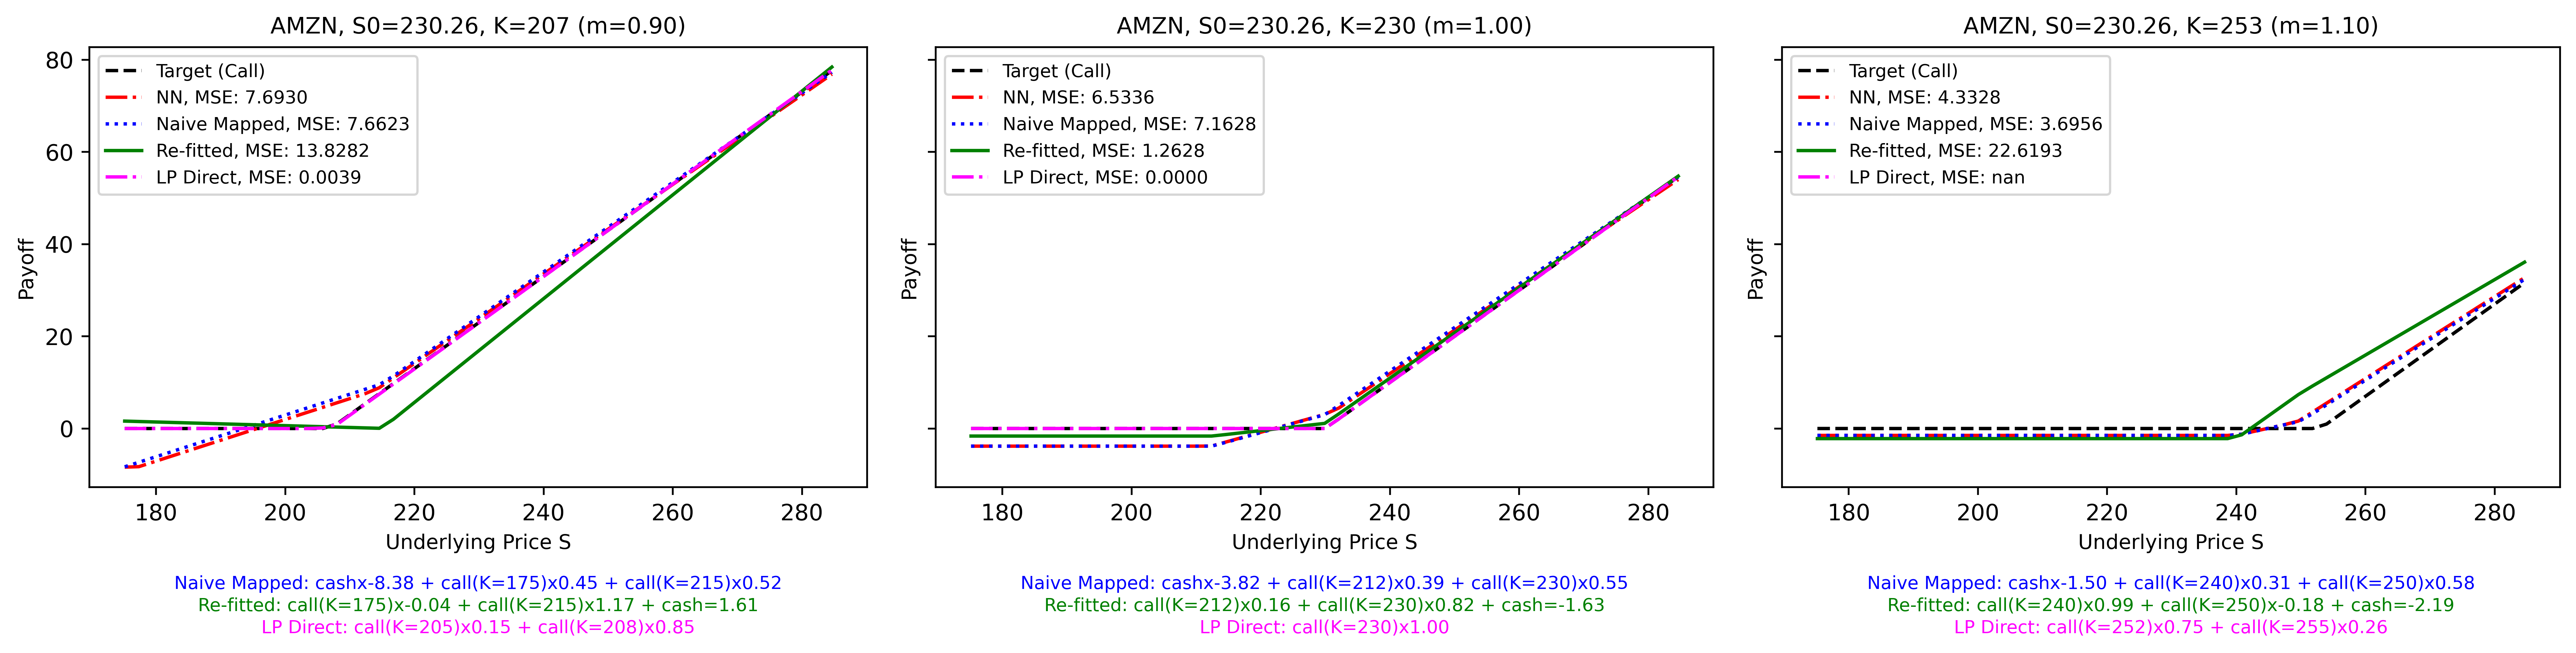

[INFO] Simulation data exported to analysis_data_AMZN_test.pkl.
Saved simulated data to c:\Users\nitai\OneDrive\MScCLS\AdvancedComputationalFinance\SemiStaticReplicationNeuralNet\analysis_data_AMZN_test.pkl


In [36]:


##################################################
# 1) Global Style Configuration
##################################################
# These dicts ensures payoff lines and portfolios use the same color consistently.
style_config = {
    'target': {
        'color': 'black',
        'linestyle': '--',
        'label': f'Target (Call)',         
        'portfolio_display': 'Target',     
        'has_bias': False
    },
    'nn': {
        'color': 'red',
        'linestyle': '-.',
        'label': 'NN, MSE: {mse:.4f}',
        'portfolio_display': 'NN',
        'has_bias': False
    },
    'mapped': {
        'color': 'blue',
        'linestyle': ':',
        'label': 'Naive Mapped, MSE: {mse:.4f}',
        'portfolio_display': 'Naive Mapped',
        'has_bias': False
    },
    'refit': {
        'color': 'green',
        'linestyle': '-',
        'label': 'Re-fitted, MSE: {mse:.4f}',
        'portfolio_display': 'Re-fitted',
        'has_bias': True   
    },
    'lp_direct': {
        'color': 'magenta',
        'linestyle': '-.',
        'label': 'LP Direct, MSE: {mse:.4f}',
        'portfolio_display': 'LP Direct',
        'has_bias': False
    },
    'lp_refitted': {
        'color': 'purple',
        'linestyle': ':',
        'label': 'LP-subset, MSE: {mse:.4f}',
        'portfolio_display': 'LP-subset',
        'has_bias': True
    }
}

##################################################
# 2) Mapping payoff keys to style keys
##################################################
payoff_line_info = {
    'target_payoff': 'target',
    'nn_payoffs': 'nn',
    'mapped_payoffs': 'mapped',
    'y_refit': 'refit',
    'lp_payoffs_direct': 'lp_direct',
    'y_lp_refit': 'lp_refitted'
}

##################################################
# 3) Mapping portfolio keys to style keys
##################################################
portfolio_info = {
    'mapped_portfolio': {
        'style_key': 'mapped',
        'offset': -0.20,         
        'bias_key': None         
    },
    'refitted_portfolio': {
        'style_key': 'refit',
        'offset': -0.25,
        'bias_key': 'refitted_bias'
    },
    'lp_direct_portfolio': {
        'style_key': 'lp_direct',
        'offset': -0.30,
        'bias_key': None
    },
    'lp_refitted_portfolio': {
        'style_key': 'lp_refitted',
        'offset': -0.35,
        'bias_key': 'lp_refitted_bias'
    }
}


def run_analysis_workflow(
    moneyness_list=None, 
    ticker_list=None,
    expiration_date='2025-01-10',
    S0=100,
    period="1mo",
    preloaded_data=None,
    export_sim_data=False,
    export_filename="analysis_results.pkl",
    plot_config=None
):
    """
    For each (ticker, moneyness):
      1) If no preloaded_data is given, fetch price & run_single_experiment
      2) Plot only the lines & replicating portfolios specified in plot_config
         (but using style_config to unify colors & line styles).
      3) Build legend, but only for lines that are actually plotted.
      4) Print replicating portfolios below each subplot, in the "manual" style
         (like your old code).
    """

    # Lazy defaults
    if moneyness_list is None:
        moneyness_list = [0.9, 1.0, 1.1]
    if ticker_list is None:
        ticker_list = ['AAPL', 'TSLA', 'NVDA']

    # Default plot_config
    if plot_config is None:
        plot_config = {
            'lines': list(payoff_line_info.keys()),
            'portfolios': list(portfolio_info.keys())
        }
        if 'target_payoff' not in plot_config['lines']:
            plot_config['lines'].insert(0, 'target_payoff')

    fig, axes = plt.subplots(
        nrows=len(ticker_list),
        ncols=len(moneyness_list),
        figsize=(16, 4),
        dpi=500,
        sharex=True,
        sharey=True
    )

    plt.subplots_adjust(bottom=0.3) 
    analysis_results = {} if preloaded_data is None else preloaded_data

    # Make sure axes is 2D
    if len(ticker_list) == 1 and len(moneyness_list) > 1:
        axes = np.array([axes])
    elif len(moneyness_list) == 1 and len(ticker_list) > 1:
        axes = axes.reshape(len(ticker_list), 1)
    elif len(ticker_list) == 1 and len(moneyness_list) == 1:
        axes = np.array([[axes]])

    # Loop over each ticker
    for i, ticker_symbol in enumerate(ticker_list):
        # If no preloaded data, fetch from yfinance
        if preloaded_data is None:
            ticker = yf.Ticker(ticker_symbol)
            hist_ago = ticker.history(period=period)
            if not hist_ago.empty:
                S0_ago = hist_ago['Close'].iloc[0]
            else:
                print(f"[WARNING] No data for {ticker_symbol}, using S0={S0} default.")
                S0_ago = S0

        # Loop over each moneyness
        for j, m in enumerate(moneyness_list):
            # If no preloaded data for this key, run the experiment
            if preloaded_data is None:
                K_TARGET = int(S0_ago * m)
                results = run_single_experiment(
                    S0=S0_ago,
                    K_TARGET=K_TARGET,
                    ticker_symbol=ticker_symbol,
                    expiration_date=expiration_date,
                    hidden_units=4,
                    lr=0.01,
                    train_epochs=300,
                    real_instrument_epochs=500,
                    lp_refit_epochs=500,
                    verbose=False
                )
                results['S0_ago'] = S0_ago
                analysis_results[(ticker_symbol, m)] = results
            else:
                if (ticker_symbol, m) not in analysis_results:
                    print(f"[WARNING] preloaded_data missing key {(ticker_symbol, m)}. Skipping.")
                    continue
                results = analysis_results[(ticker_symbol, m)]
                S0_ago = results.get('S0_ago', S0)

            # Current subplot
            ax = axes[i, j] if (len(ticker_list) > 1 or len(moneyness_list) > 1) else axes

            S_test = results['S_test']
            target_payoff_array = results.get('target_payoff_vec')

            # --- Plot lines in plot_config['lines'] ---
            line_handles = []
            line_labels = []
            for payoff_key in plot_config['lines']:
                if payoff_key not in payoff_line_info:
                    continue
                payoff_array = (
                    results.get('target_payoff_vec') if payoff_key == 'target_payoff'
                    else results.get(payoff_key)
                )
                if payoff_array is None:
                    continue  # skip if missing

                style_id = payoff_line_info[payoff_key]
                line_style = style_config[style_id]['linestyle']
                line_color = style_config[style_id]['color']
                label_template = style_config[style_id]['label']

                # MSE if we have a target
                if (target_payoff_array is not None) and (payoff_key != 'target_payoff'):
                    mse_val = np.mean((payoff_array - target_payoff_array)**2)
                else:
                    mse_val = 0.0

                if '{mse' in label_template:
                    line_label = label_template.format(mse=mse_val)
                else:
                    line_label = label_template

                (ln,) = ax.plot(
                    S_test, payoff_array,
                    linestyle=line_style,
                    color=line_color,
                    linewidth=1.5
                )
                line_handles.append(ln)
                line_labels.append(line_label)

            if line_handles:
                ax.legend(line_handles, line_labels, loc='upper left', fontsize=8)

            ax.set_title(f"{ticker_symbol}, S0={S0_ago:.2f}, K={int(S0_ago*m)} (m={m:.2f})", fontsize=10)
            ax.set_xlabel("Underlying Price S", fontsize=9)
            ax.set_ylabel("Payoff", fontsize=9)

           # --- Print portfolios below each subplot ---
            mapped_portfolio = results.get('mapped_portfolio', [])
            if mapped_portfolio:
                mp_str_parts = []
                for p in mapped_portfolio:
                    instr = p.get('instrument', '???')
                    strike = p.get('strike')
                    w = p.get('units', 0.0)
                    if strike is not None:
                        mp_str_parts.append(f"{instr}(K={strike:.0f})x{w:.2f}")
                    else:
                        mp_str_parts.append(f"{instr}x{w:.2f}")
                mp_text = " + ".join(mp_str_parts)
                ax.text(
                    0.5, -0.20,
                    f"Naive Mapped: {mp_text}",
                    transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    color='blue'
                )

            refitted_portfolio = results.get('refitted_portfolio', [])
            refitted_bias = results.get('refitted_bias', 0.0)
            if refitted_portfolio:
                rf_str_parts = []
                for p in refitted_portfolio:
                    instr = p.get('instrument', '???')
                    strike = p.get('strike')
                    w = p.get('weight', 0.0)
                    if strike is not None:
                        rf_str_parts.append(f"{instr}(K={strike:.0f})x{w:.2f}")
                    else:
                        rf_str_parts.append(f"{instr}x{w:.2f}")
                rf_text = " + ".join(rf_str_parts)
                rf_text += f" + cash={refitted_bias:.2f}"
                ax.text(
                    0.5, -0.25,
                    f"Re-fitted: {rf_text}",
                    transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    color='green'
                )

            lp_direct_portfolio = results.get('lp_direct_portfolio', [])
            if lp_direct_portfolio:
                ld_str_parts = []
                for p in lp_direct_portfolio:
                    instr = p.get('instrument', '???')
                    strike = p.get('strike')
                    w = p.get('weight', 0.0)
                    if strike is not None:
                        ld_str_parts.append(f"{instr}(K={strike:.0f})x{w:.2f}")
                    else:
                        ld_str_parts.append(f"{instr}x{w:.2f}")
                ld_text = " + ".join(ld_str_parts)
                ax.text(
                    0.5, -0.30,
                    f"LP Direct: {ld_text}",
                    transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    color='magenta'
                )

            # lp_sub_portfolio = results.get('lp_refitted_portfolio', [])
            # lp_sub_bias = results.get('lp_refitted_bias', 0.0)
            # if lp_sub_portfolio:
            #     lp_str_parts = []
            #     for p in lp_sub_portfolio:
            #         instr = p.get('instrument', '???')
            #         strike = p.get('strike')
            #         w = p.get('weight', 0.0)
            #         if strike is not None:
            #             lp_str_parts.append(f"{instr}(K={strike:.0f})x{w:.2f}")
            #         else:
            #             lp_str_parts.append(f"{instr}x{w:.2f}")
            #     lp_text = " + ".join(lp_str_parts)
            #     lp_text += f" + cash={lp_sub_bias:.2f}"
            #     ax.text(
            #         0.5, -0.35,
            #         f"LP-subset: {lp_text}",
            #         transform=ax.transAxes,
            #         ha='center', va='top', fontsize=8,
            #         color='purple'
            #     )

    plt.tight_layout(h_pad=2.5)
    plt.show()

    if export_sim_data:
        with open(export_filename, "wb") as f:
            pickle.dump(analysis_results, f)
        print(f"[INFO] Simulation data exported to {export_filename}.")

    return analysis_results



###########################################
# Simulating
###########################################
# Full config that shows every payoff line and every replicating portfolio, can comment in our out to show different lines
plot_config_all = {
        'lines': [
            'target_payoff',
            'nn_payoffs',
            'mapped_payoffs',
            'y_refit',
            'lp_payoffs_direct',
            # 'y_lp_refit'
        ],
        'portfolios': [
            'mapped_portfolio',
            'refitted_portfolio',
            'lp_direct_portfolio',
            # 'lp_refitted_portfolio'
        ]
    }

export_file = "analysis_data_AMZN_test.pkl"

analysis_results = run_analysis_workflow(
    moneyness_list=[0.9, 1.0, 1.1],
    ticker_list=['AMZN'],
    expiration_date='2025-01-17',
    S0=100,
    period="1mo",
    export_sim_data=True,               # <--- TO export sim data
    export_filename=export_file,        # <--- Will save here
    plot_config=plot_config_all
)

print(f"Saved simulated data to {Path(export_file).absolute()}")


## Plotting only using saved data

Loaded data from c:\Users\nitai\OneDrive\MScCLS\AdvancedComputationalFinance\SemiStaticReplicationNeuralNet\analysis_data_AAPL.pkl


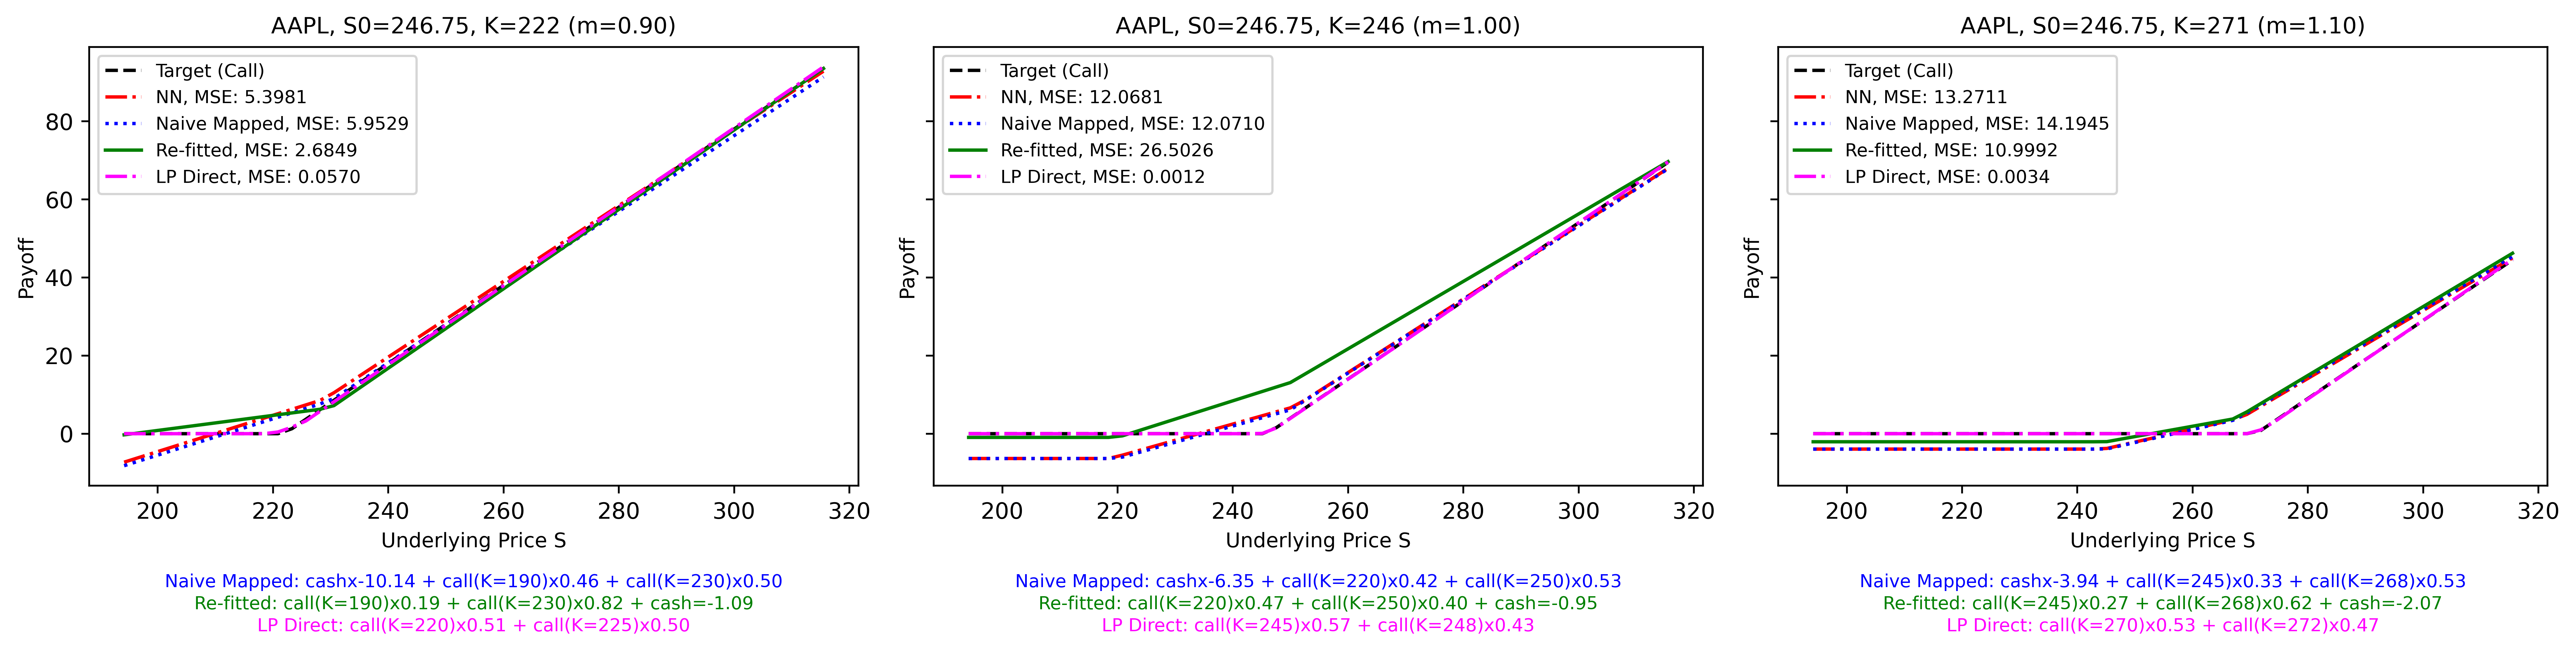

{('AAPL',
  0.9): {'S_test': array([194.15999756, 196.58699753, 199.0139975 , 201.44099747,
         203.86799744, 206.29499741, 208.72199738, 211.14899734,
         213.57599731, 216.00299728, 218.42999725, 220.85699722,
         223.28399719, 225.71099716, 228.13799713, 230.5649971 ,
         232.99199707, 235.41899704, 237.84599701, 240.27299698,
         242.69999695, 245.12699692, 247.55399689, 249.98099686,
         252.40799683, 254.8349968 , 257.26199677, 259.68899673,
         262.1159967 , 264.54299667, 266.96999664, 269.39699661,
         271.82399658, 274.25099655, 276.67799652, 279.10499649,
         281.53199646, 283.95899643, 286.3859964 , 288.81299637,
         291.23999634, 293.66699631, 296.09399628, 298.52099625,
         300.94799622, 303.37499619, 305.80199615, 308.22899612,
         310.65599609, 313.08299606, 315.50999603]), 'target_payoff_vec': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,

In [ ]:
# Full config that shows every payoff line and every replicating portfolio
plot_config_all = {
        'lines': [
            'target_payoff',
            'nn_payoffs',
            'mapped_payoffs',
            'y_refit',
            'lp_payoffs_direct',
            # 'y_lp_refit'
        ],
        'portfolios': [
            'mapped_portfolio',
            'refitted_portfolio',
            'lp_direct_portfolio',
            # 'lp_refitted_portfolio'
        ]
    }


export_file = "analysis_data_AAPL.pkl"

with open(export_file, "rb") as f:
    pre_data = pickle.load(f)
    print(f"Loaded data from {Path(export_file).absolute()}")

# Use pre_data to skip re-simulation
run_analysis_workflow(
    moneyness_list=[0.9, 1.0, 1.1],
    ticker_list=['AAPL'],
    expiration_date='2025-01-17',
    S0=100,
    period="1mo",
    preloaded_data=pre_data,   
    plot_config=plot_config_all
)



Loaded data from c:\Users\nitai\OneDrive\MScCLS\AdvancedComputationalFinance\SemiStaticReplicationNeuralNet\analysis_data_AMZN_new.pkl


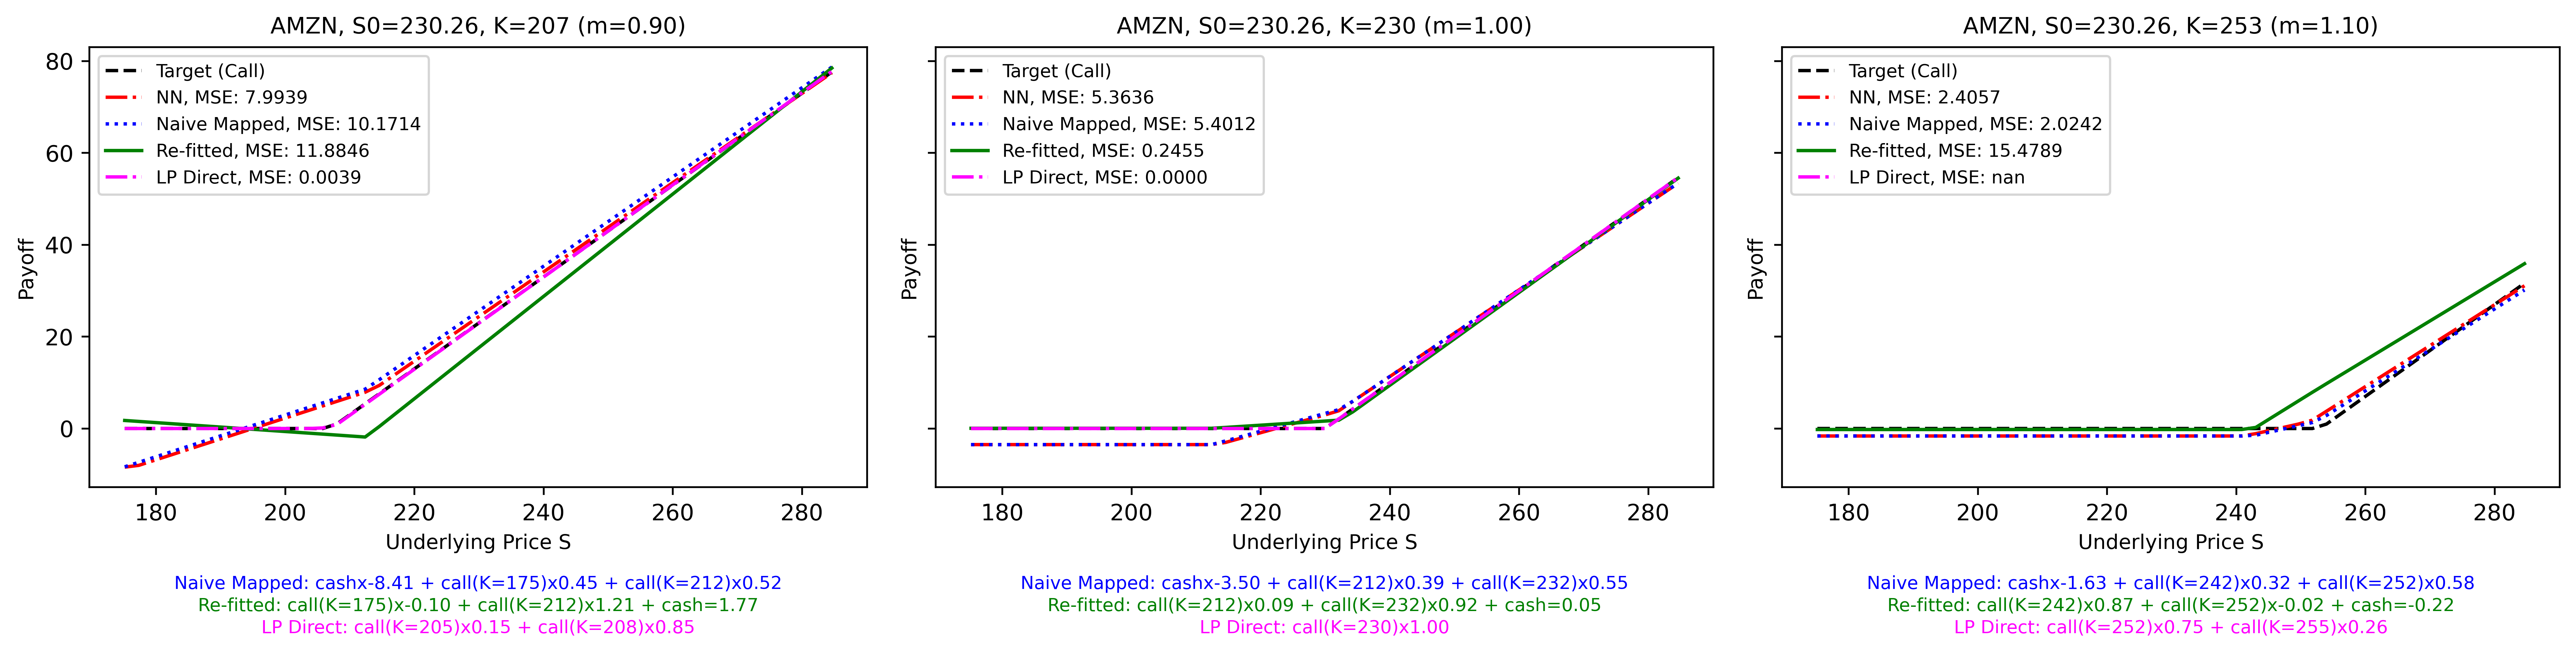

{('AMZN',
  0.9): {'S_test': array([175.15200195, 177.34140198, 179.530802  , 181.72020203,
         183.90960205, 186.09900208, 188.2884021 , 190.47780212,
         192.66720215, 194.85660217, 197.0460022 , 199.23540222,
         201.42480225, 203.61420227, 205.80360229, 207.99300232,
         210.18240234, 212.37180237, 214.56120239, 216.75060242,
         218.94000244, 221.12940247, 223.31880249, 225.50820251,
         227.69760254, 229.88700256, 232.07640259, 234.26580261,
         236.45520264, 238.64460266, 240.83400269, 243.02340271,
         245.21280273, 247.40220276, 249.59160278, 251.78100281,
         253.97040283, 256.15980286, 258.34920288, 260.53860291,
         262.72800293, 264.91740295, 267.10680298, 269.296203  ,
         271.48560303, 273.67500305, 275.86440308, 278.0538031 ,
         280.24320313, 282.43260315, 284.62200317]), 'target_payoff_vec': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,

In [29]:
# Full config that shows every payoff line and every replicating portfolio
plot_config_all = {
        'lines': [
            'target_payoff',
            'nn_payoffs',
            'mapped_payoffs',
            'y_refit',
            'lp_payoffs_direct',
            # 'y_lp_refit'
        ],
        'portfolios': [
            'mapped_portfolio',
            'refitted_portfolio',
            'lp_direct_portfolio',
            # 'lp_refitted_portfolio'
        ]
    }


export_file = "analysis_data_AMZN_new.pkl"

with open(export_file, "rb") as f:
    pre_data = pickle.load(f)
    print(f"Loaded data from {Path(export_file).absolute()}")

# Use pre_data to skip re-simulation
run_analysis_workflow(
    moneyness_list=[0.9, 1.0, 1.1],
    ticker_list=['AMZN'],
    expiration_date='2025-01-17',
    S0=100,
    period="1mo",
    preloaded_data=pre_data,   
    plot_config=plot_config_all
)

Loaded data from c:\Users\nitai\OneDrive\MScCLS\AdvancedComputationalFinance\SemiStaticReplicationNeuralNet\analysis_data_SPY_new.pkl


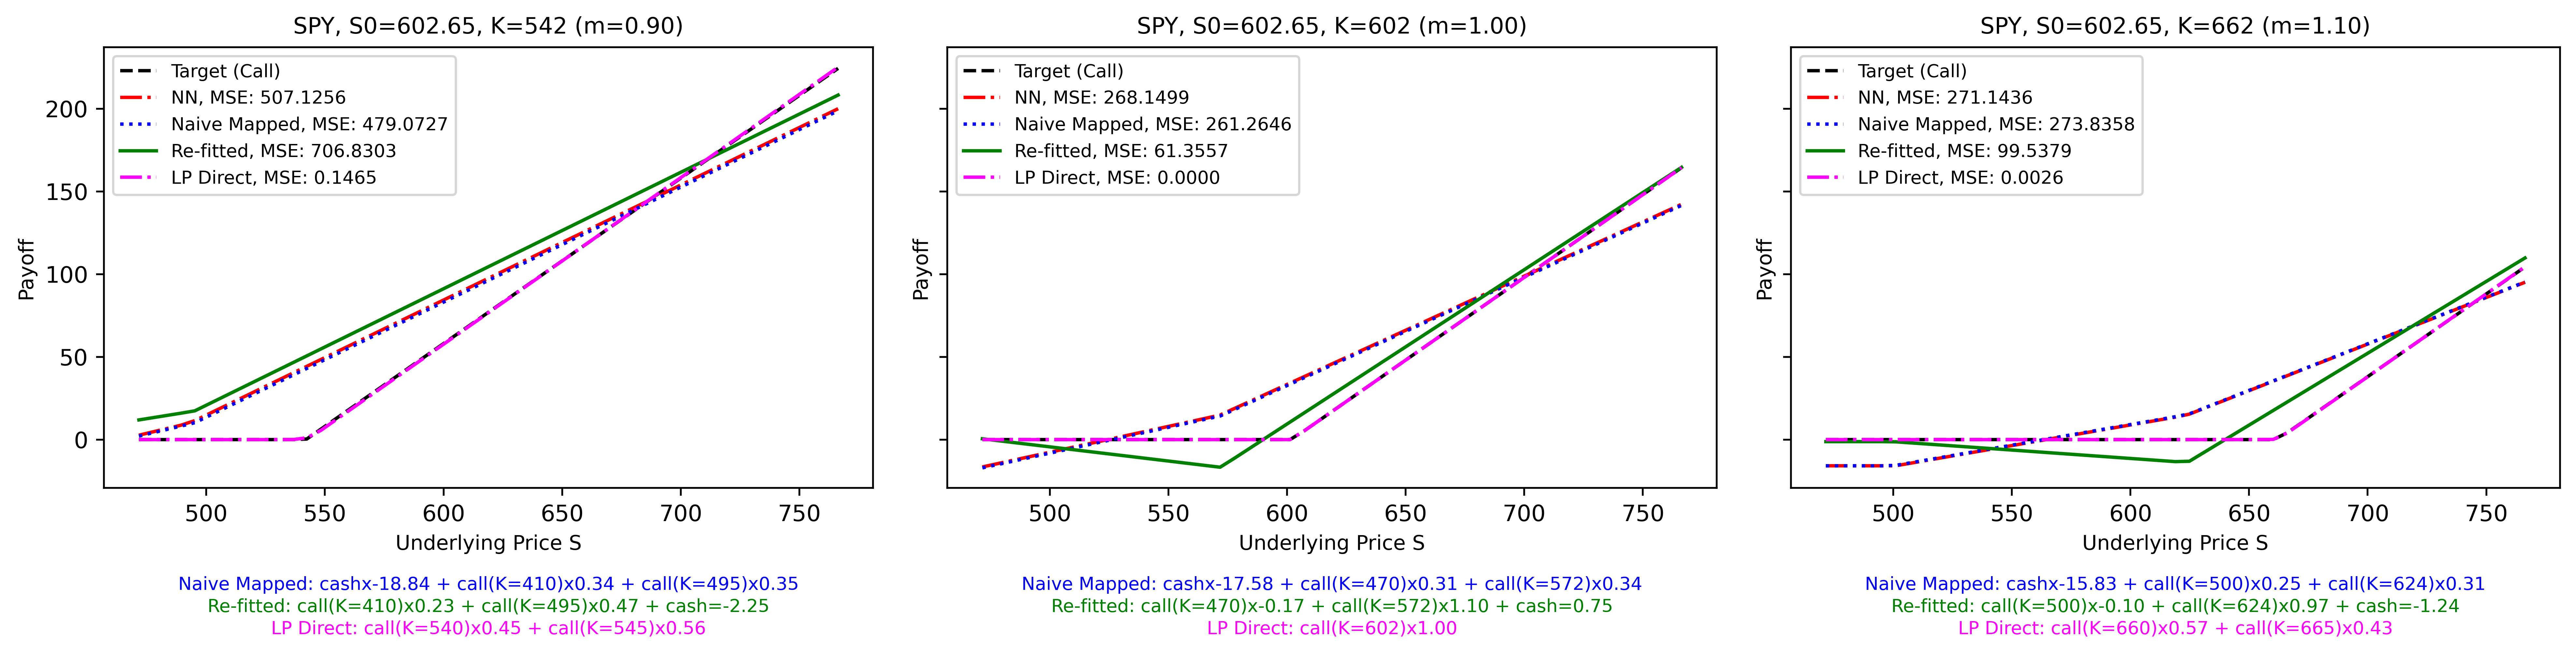

{('SPY',
  0.9): {'S_test': array([471.59199219, 477.48689209, 483.38179199, 489.27669189,
         495.1715918 , 501.0664917 , 506.9613916 , 512.8562915 ,
         518.75119141, 524.64609131, 530.54099121, 536.43589111,
         542.33079102, 548.22569092, 554.12059082, 560.01549072,
         565.91039062, 571.80529053, 577.70019043, 583.59509033,
         589.48999023, 595.38489014, 601.27979004, 607.17468994,
         613.06958984, 618.96448975, 624.85938965, 630.75428955,
         636.64918945, 642.54408936, 648.43898926, 654.33388916,
         660.22878906, 666.12368896, 672.01858887, 677.91348877,
         683.80838867, 689.70328857, 695.59818848, 701.49308838,
         707.38798828, 713.28288818, 719.17778809, 725.07268799,
         730.96758789, 736.86248779, 742.7573877 , 748.6522876 ,
         754.5471875 , 760.4420874 , 766.3369873 ]), 'target_payoff_vec': array([  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.  

In [12]:
# Full config that shows every payoff line and every replicating portfolio
plot_config_all = {
        'lines': [
            'target_payoff',
            'nn_payoffs',
            'mapped_payoffs',
            'y_refit',
            'lp_payoffs_direct',
            # 'y_lp_refit'
        ],
        'portfolios': [
            'mapped_portfolio',
            'refitted_portfolio',
            'lp_direct_portfolio',
            # 'lp_refitted_portfolio'
        ]
    }


export_file = "analysis_data_SPY_new.pkl"

with open(export_file, "rb") as f:
    pre_data = pickle.load(f)
    print(f"Loaded data from {Path(export_file).absolute()}")

# Use pre_data to skip re-simulation
run_analysis_workflow(
    moneyness_list=[0.9, 1.0, 1.1],
    ticker_list=['SPY'],
    expiration_date='2025-01-17',
    S0=100,
    period="1mo",
    preloaded_data=pre_data,   
    plot_config=plot_config_all
)